# Experiment overview

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns

from config import SET_MAPPING
# create an emty dataframe
rq1_results = pd.DataFrame()

In [10]:
cq_df = pd.read_csv("../data/bme_cq_measures.csv")
cqs = [cq for cq in cq_df["cq"].to_list() if cq is not None and len(cq) > 5]

print(f"Loaded {len(cqs)} CQs from {cq_df.shape[0]} rows")

Loaded 204 CQs from 204 rows


In [ ]:
#select rows from cq_df where set == 3 and ambiguity == 1
for cq in cq_df[(cq_df["set"] == 3) & (cq_df["ambiguity"] == 1)]['cq']:
    print(cq)


 What security measures do I need to display an item?
What is the loan start date of an item to the British Music Experience?
Find items with a (specific) loan start date?
How many years does the loan agreement cover the Ziggy Stardust Jumpsuit?
What an item has the serial number (Unique identifier)?


In [3]:
askcq_df = pd.read_csv("../data/askcq_dataset.csv")  # <--- use full set!
cqs = [cq for cq in askcq_df["cq"].to_list() if cq is not None and len(cq) > 5]

print(f"Loaded {len(cqs)} CQs from {askcq_df.shape[0]} rows")


Loaded 204 CQs from 204 rows


In [4]:
# Replace the column attribute with 1 if the column contains some text otherwise 0
askcq_df['comment'] = askcq_df['comment']\
    .apply(lambda x: 1 if isinstance(x, str) and len(x) > 0 else 0)
# column as type int
askcq_df['comment'] = askcq_df['comment'].astype(int)
askcq_df['ambiguity'] = askcq_df['ambiguity'].astype(int)


In [5]:
# For each CQ set, print the proportion CQ that received a comment (value 1) per CQ set
# (numbers in the 'set' column are mapped to names in the SET_MAPPING dict)
def get_proportion_cqs_with_comments(df):
    # Get the number of CQs per set
    set_counts = df['set'].value_counts()
    # Get the number of CQs with comments per set
    set_comment_counts = df[df['comment'] == 1]['set'].value_counts()
    # Get the proportion of CQs with comments per set
    proportions = set_comment_counts / set_counts
    # Map the set numbers to names
    proportions.index = [SET_MAPPING[set_num] for set_num in proportions.index]
    return proportions
# Get the proportion of CQs with comments per set
proportions = get_proportion_cqs_with_comments(askcq_df)
rq1_results['comments'] = proportions
rq1_results

,comments
HA-1,0.272727
HA-2,0.185185
Pattern,0.368421
GPT4.1,0.346154
Gemini 2.5 Pro,0.309524


In [6]:
cq_df = askcq_df

## Score distribution and inter-annotator agreement (RQ1)

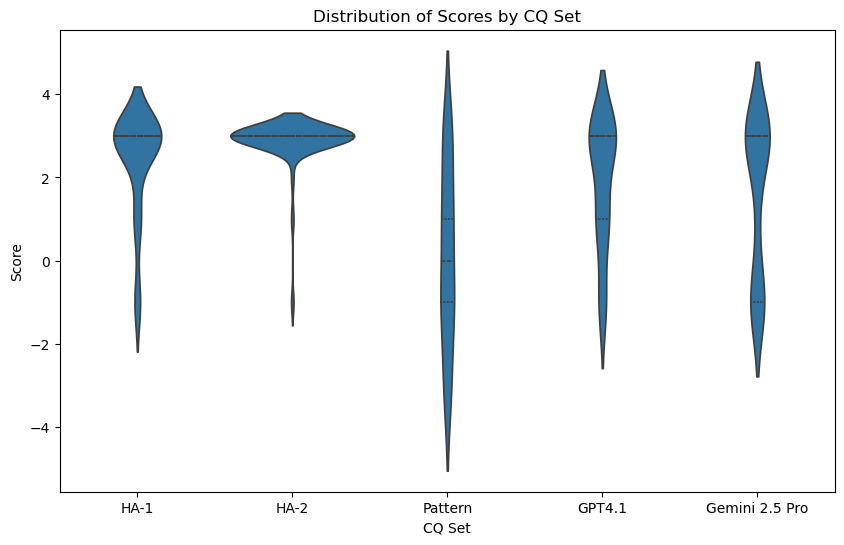

In [7]:
def plot_score_distribution(cq_df):
    """
    Plot the distribution of the scores for each set.
    """
    plt.figure(figsize=(10, 6))
    sns.violinplot(x="set", y="score", data=cq_df, inner="quartile")
    plt.xticks(ticks=[0, 1, 2, 3, 4], labels=["HA-1", "HA-2", "Pattern", "GPT4.1", "Gemini 2.5 Pro"])
    plt.xlabel("CQ Set")
    plt.ylabel("Score")
    plt.title("Distribution of Scores by CQ Set")
    plt.show()

plot_score_distribution(cq_df)

In [8]:
# Print the mean and std of the scores for each set
def print_score_stats(cq_df):
    """
    Print the mean and std of the scores for each set.
    """
    # Get the mean and std of the scores for each set
    stats = cq_df.groupby("set")["score"].agg(["mean", "std"])
    # Map the set numbers to names
    stats.index = [SET_MAPPING[set_num] for set_num in stats.index]
    return stats
# Get the mean and std of the scores for each set
stats = print_score_stats(cq_df)
rq1_results['score_mean'] = stats['mean']
rq1_results['score_std'] = stats['std']
rq1_results

,comments,score_mean,score_std
HA-1,0.272727,2.386364,1.261522
HA-2,0.185185,2.870370,0.615715
Pattern,0.368421,0.105263,2.115445
GPT4.1,0.346154,1.846154,1.515053
Gemini 2.5 Pro,0.309524,1.523810,1.877181


In [9]:
# Print the proportion of CQs in each set that received a score > 0
def print_proportion_cqs_with_score_gt_0(cq_df):
    """
    Print the proportion of CQs in each set that received a score > 0.
    """
    # Get the number of CQs per set
    set_counts = cq_df['set'].value_counts()
    # Get the number of CQs with score > 0 per set
    set_score_counts = cq_df[cq_df['score'] > 0]['set'].value_counts()
    # Get the proportion of CQs with score > 0 per set
    proportions = set_score_counts / set_counts
    # Map the set numbers to names
    proportions.index = [SET_MAPPING[set_num] for set_num in proportions.index]
    return proportions
# Get the proportion of CQs with score > 0 per set
proportions = print_proportion_cqs_with_score_gt_0(cq_df)
# update the rq1_results dataframe with the proportions
rq1_results['accepted_cqs_proportion'] = proportions
rq1_results

,comments,score_mean,score_std,accepted_cqs_proportion
HA-1,0.272727,2.386364,1.261522,0.909091
HA-2,0.185185,2.870370,0.615715,0.981481
Pattern,0.368421,0.105263,2.115445,0.500000
GPT4.1,0.346154,1.846154,1.515053,0.846154
Gemini 2.5 Pro,0.309524,1.523810,1.877181,0.666667


## Version 2.0 analysis: 3 annotators

In [11]:
# Basically we need a measure for N=3 annotators, so we use Fleiss' Kappa
# --- Interpretation Guidelines (Landis & Koch, 1977 - generally applied to Fleiss' Kappa too) ---
# < 0: Poor agreement (worse than chance)
# 0.01 – 0.20: Slight agreement
# 0.21 – 0.40: Fair agreement
# 0.41 – 0.60: Moderate agreement
# 0.61 – 0.80: Substantial agreement
# 0.81 – 1.00: Almost perfect agreement

from agreement import calculate_fleiss_kappa_from_scores

# Calculate overall Fleiss' Kappa
overall_kappa = calculate_fleiss_kappa_from_scores(cq_df)
print(f"Overall Fleiss' Kappa: {overall_kappa:.4f}\n")
# Calculate Fleiss' Kappa per set
kappa_by_set = calculate_fleiss_kappa_from_scores(
    cq_df, group_by_col='set', set_mapping=SET_MAPPING)

print("Fleiss' Kappa by Set:")
if isinstance(kappa_by_set, dict):
    for set_name, kappa in kappa_by_set.items():
        print(f"- {set_name}: {kappa:.4f}")
else:
     print("Could not calculate Kappa by set!")

Overall Fleiss' Kappa: 0.3539

Fleiss' Kappa by Set:
- HA-1: 0.2301
- HA-2: 0.3205
- Pattern: 0.2271
- GPT4.1: 0.0921
- Gemini 2.5 Pro: 0.2727


### Version 1.0 analysis: first 2 annotators

In [5]:
def calculate_cohen_kappa_from_scores(df: pd.DataFrame, score_column: str = 'score') -> float:
    """
    Calculates Cohen's Kappa for inter-annotator agreement based on summary scores.

    Assumes scores represent agreement/disagreement between two annotators:
    +2: Both agree 'accept'
    -2: Both agree 'reject'
     0: Disagreement
    
    Interpretation: General guidelines from (Landis & Koch, 1977):
     < 0: Poor agreement
     0.01 - 0.20: Slight agreement
     0.21 - 0.40: Fair agreement
     0.41 - 0.60: Moderate agreement
     0.61 - 0.80: Substantial agreement
     0.81 - 1.00: Almost perfect agreement

    Args:
        df: Pandas DataFrame containing the scores.
        score_column: The name of the column containing the scores (-2, 0, +2).

    Returns:
        Cohen's Kappa (κ) value. Returns np.nan if calculation is not possible
        (e.g., no agreement, Pe=1).
    """
    scores = df[score_column]
    N = len(scores)

    if N == 0:
        print("Warning: DataFrame is empty.")
        return np.nan

    # Count occurrences of each score
    counts = scores.value_counts()
    N_plus2 = counts.get(2, 0)
    N_minus2 = counts.get(-2, 0)
    N_0 = counts.get(0, 0)

    # Ensure total counts match DataFrame length
    if N_plus2 + N_minus2 + N_0 != N:
        print(f"Warning: Sum of counts ({N_plus2 + N_minus2 + N_0}) does not match total N ({N}). Check for unexpected score values.")
        # Filter out unexpected scores for calculation if needed, or return NaN
        valid_scores = scores[scores.isin([2, -2, 0])]
        N = len(valid_scores)
        if N == 0: return np.nan
        counts = valid_scores.value_counts()
        N_plus2 = counts.get(2, 0)
        N_minus2 = counts.get(-2, 0)
        N_0 = counts.get(0, 0)


    # 1. Calculate Observed Agreement (Po)
    num_agreed = N_plus2 + N_minus2
    Po = num_agreed / N if N > 0 else 0

    # 2. Calculate Expected Agreement (Pe)
    total_decisions = 2 * N
    if total_decisions == 0:
        print("Warning: No decisions found (N=0).")
        return np.nan # Or handle as appropriate

    num_accepts = (2 * N_plus2) + N_0
    num_rejects = (2 * N_minus2) + N_0

    P_accept = num_accepts / total_decisions
    P_reject = num_rejects / total_decisions # or 1 - P_accept

    Pe = P_accept**2 + P_reject**2

    # 3. Calculate Cohen's Kappa (κ)
    if abs(1.0 - Pe) < 1e-9: # Check if Pe is close to 1 (denominator is zero)
        print("Warning: Expected agreement (Pe) is 1. Kappa is undefined or 0.")
        # If Po is also 1, it's perfect agreement, sometimes reported as 1,
        # but often undefined or 0 by the formula logic.
        return 1.0 if abs(1.0 - Po) < 1e-9 else 0.0 # Or return np.nan
    else:
        kappa = (Po - Pe) / (1 - Pe)
        return kappa


def compute_decision_kappa(cq_df, agreement_score=2):
    """
    Compute Cohen's Kappa coefficient for inter-annotator agreement.
    Notation:
    p0 = proportion of observed agreement
    pe = proportion of expected agreement
    """
    n = cq_df.shape[0]
    p0 = (cq_df["score"] == agreement_score).sum() / n
    pe = ((cq_df["score"] == 2).sum() / n) * ((cq_df["score"] == -2).sum() / n)
    kappa = (p0 - pe) / (1 - pe)
    return kappa


def compute_kappa_by_set(cq_df):
    """
    Compute Cohen's Kappa coefficient for inter-annotator agreement by set.
    """
    kappa_by_set = {}
    for set_num, set_name in SET_MAPPING.items():
        set_df = cq_df[cq_df["set"] == set_num]
        # Store the Kappa value in the dictionary
        kappa_by_set[set_name] = {
            "overall": calculate_cohen_kappa_from_scores(set_df),
            "acceptance": compute_decision_kappa(set_df, 2),
            "rejection": compute_decision_kappa(set_df, -2),
        }
    return kappa_by_set


In [6]:
kappa = compute_decision_kappa(cq_df, 2)
print(f"Inter-annotator (ACCEPTANCE) agreement: {kappa:.2f} (Cohen's Kappa)")
kappa = compute_decision_kappa(cq_df, -2)
print(f"Inter-annotator (REJECTION) agreement: {kappa:.2f} (Cohen's Kappa)")
kappa = calculate_cohen_kappa_from_scores(cq_df)
print(f"Inter-annotator overall agreement: {kappa:.2f} (Cohen's Kappa)")
# The Kappa coefficient is a measure of inter-annotator agreement for categorical
# items. It is generally considered that a Kappa value of 0.61-0.80 indicates
# substantial agreement, and a value of 0.81-1.00 indicates almost perfect agreement.

Inter-annotator (ACCEPTANCE) agreement: 0.68 (Cohen's Kappa)
Inter-annotator (REJECTION) agreement: 0.02 (Cohen's Kappa)
Inter-annotator overall agreement: 0.15 (Cohen's Kappa)


In [7]:
kappa_by_set = compute_kappa_by_set(cq_df)
print("Inter-annotator agreement by set:")
for set_name, kappa in kappa_by_set.items():
    # Print the Kappa values for each set in the same line
    print(f"{set_name}: {kappa['overall']:.2f} (Overall), {kappa['acceptance']:.2f} (Acceptance), {kappa['rejection']:.2f} (Rejection)")

Inter-annotator agreement by set:
HA-1: -0.07 (Overall), 0.86 (Acceptance), 0.00 (Rejection)
HA-2: -0.02 (Overall), 0.96 (Acceptance), 0.00 (Rejection)
Pattern: 0.05 (Overall), 0.18 (Acceptance), 0.24 (Rejection)
GPT4.1: -0.21 (Overall), 0.65 (Acceptance), 0.00 (Rejection)
Gemini 2.5 Pro: -0.24 (Overall), 0.62 (Acceptance), 0.00 (Rejection)


### Feature overview: Ambiguity

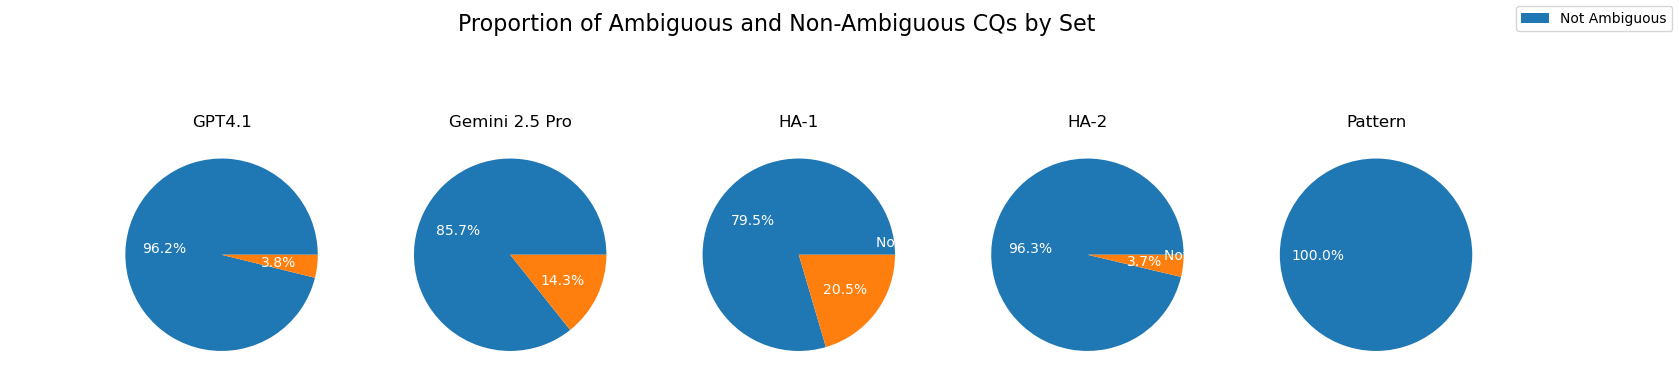

In [12]:
cq_df

# keep cq, set, score, ambiguity
cq_df = cq_df[["cq", "set", "score", "ambiguity"]]

# ambiguity is either 0 (not ambiguous) or 1 (ambiguous), therefore, plot
# the proportion of ambiguous CQs for each set as a pie chart for each set
# showing the proportion of ambiguous and non-ambiguous CQs within the same plot

# Group the data by set and ambiguity, then count occurrences
grouped_df = cq_df.groupby(["set", "ambiguity"]).size().reset_index(name="count")
grouped_df["set_name"] = grouped_df["set"].map(SET_MAPPING)

# Create a subplot for the pie charts
fig, axes = plt.subplots(1, len(grouped_df["set_name"].unique()),
                         figsize=(18, 5), subplot_kw=dict(aspect="equal"))

# Generate pie charts for each set
for ax, (set_name, group) in zip(axes, grouped_df.groupby("set_name")):
    wedges, texts, autotexts = ax.pie(
        group["count"],
        labels=["Not Ambiguous", "Ambiguous"] if 1 in group["ambiguity"].values else ["Not Ambiguous"],
        autopct='%1.1f%%', textprops=dict(color="w")
    )
    ax.set_title(f"{set_name}")

# Add a single legend for all subplots
fig.legend(wedges, ["Not Ambiguous", "Ambiguous"], loc="upper right")
plt.suptitle("Proportion of Ambiguous and Non-Ambiguous CQs by Set", fontsize=16)
plt.show()


In [9]:

# From the cq_df only keep the columns cq, set, score, and ambiguity
cq_main_df = cq_df[["cq", "set", "score", "ambiguity"]]  # with score and amb.

# Now we read the dataframe with the other metrics that we need to join
cq_complexity_df = pd.read_csv("../data/bme_cq_complexity.csv")
cq_readability_df = pd.read_csv("../data/bme_cq_readability.csv")
cq_relevance_df = pd.read_csv("../data/bme_cq_relevance_ge25p_aa_score.csv")

In [10]:
# Drop the length and set columns from the complexity dataframe
cq_complexity_df = cq_complexity_df.drop(columns=["length"])
cq_complexity_df = cq_complexity_df.drop(columns=["set"])

# Remove all columns ending with '_scaled' from the readability dataframe
cq_readability_df = cq_readability_df.loc[:, ~cq_readability_df.columns.str.endswith('_scaled')]
cq_readability_df = cq_readability_df.drop(columns=["set"])

In [11]:
# Now merge all the daframes together on the cq column
cq_measures_df = cq_main_df.merge(cq_complexity_df, on="cq", how="left")
cq_measures_df = cq_measures_df.merge(cq_readability_df, on="cq", how="left")
cq_measures_df = cq_measures_df.merge(cq_relevance_df, on="cq", how="left")

# Make sure that the number of rows is the same as the original dataframe
# assert cq_measures_df.shape[0] == cq_df.shape[0]

In [12]:
cq_measures_df

,cq,set,score,ambiguity,c0_length,c1_complexity,c1_concepts,c1_properties,c1_relationships,c1_filters,...,c3_node_count,c3_tree_depth,c3_total_relevant_deps,read_fkgl,read_gfi,read_cli,read_ari,read_dcr,relevance_score,relevance_rationale
0,Are there images of the item being used or cre...,1,2,1,65.0,9.0,3.0,1.0,3.0,1.0,...,13.0,8.0,8.0,7.2,11.35,5.03,4.3,7.93,4,The user story explicitly states that Sonia co...
1,When is a loaned item expected to be returned?,1,2,0,46.0,4.0,2.0,1.0,1.0,0.0,...,9.0,4.0,5.0,4.4,8.04,4.78,2.9,11.10,4,The user story explicitly states that 'loan ag...
2,Is the artefact out for repair?,1,2,0,31.0,4.0,2.0,1.0,0.0,0.0,...,6.0,2.0,3.0,2.1,2.40,3.35,2.0,6.57,3,"The user story emphasizes tracking 'condition,..."
3,What type of artist is Queen?,1,2,0,29.0,4.0,2.0,1.0,1.0,0.0,...,6.0,3.0,4.0,0.9,2.40,1.38,0.4,6.57,3,"The user story explicitly states that ""Associa..."
4,What are the types of the artefacts that be di...,1,2,0,54.0,4.0,1.0,1.0,0.0,1.0,...,10.0,5.0,6.0,2.5,4.00,6.76,4.8,8.87,4,The user story explicitly mentions that artefa...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,How can the system represent the relationship ...,5,0,0,105.0,6.0,2.0,1.0,1.0,1.0,...,19.0,6.0,9.0,9.9,13.86,11.77,11.8,10.98,4,The user story explicitly states that Sonia (t...
201,How can the system represent the status of a l...,5,0,0,94.0,2.0,1.0,1.0,0.0,0.0,...,20.0,7.0,10.0,6.2,8.33,7.79,7.4,13.48,4,The user story explicitly states that Sonia sh...
202,What information about loaned artifacts should...,5,0,0,169.0,15.0,5.0,4.0,3.0,2.0,...,33.0,4.0,14.0,12.7,16.47,14.49,13.2,15.42,4,The user story explicitly states: 'Sonia is gr...
203,How does the system distinguish between artifa...,5,0,0,97.0,5.0,1.0,1.0,0.0,2.0,...,16.0,6.0,12.0,9.5,13.90,11.77,10.7,10.35,4,The user story explicitly details that the sys...


In [13]:
cq_measures_df.columns

Index(['cq', 'set', 'score', 'ambiguity', 'c0_length', 'c1_complexity',
       'c1_concepts', 'c1_properties', 'c1_relationships', 'c1_filters',
       'c1_cardinality_hint', 'c1_aggregation_hint', 'c2_complexity',
       'c2_num_verbs', 'c2_num_prepositions', 'c2_num_conjunctions',
       'c2_num_modifiers', 'c2_num_noun_phrases', 'c3_complexity',
       'c3_node_count', 'c3_tree_depth', 'c3_total_relevant_deps', 'read_fkgl',
       'read_gfi', 'read_cli', 'read_ari', 'read_dcr', 'relevance_score',
       'relevance_rationale'],
      dtype='object')

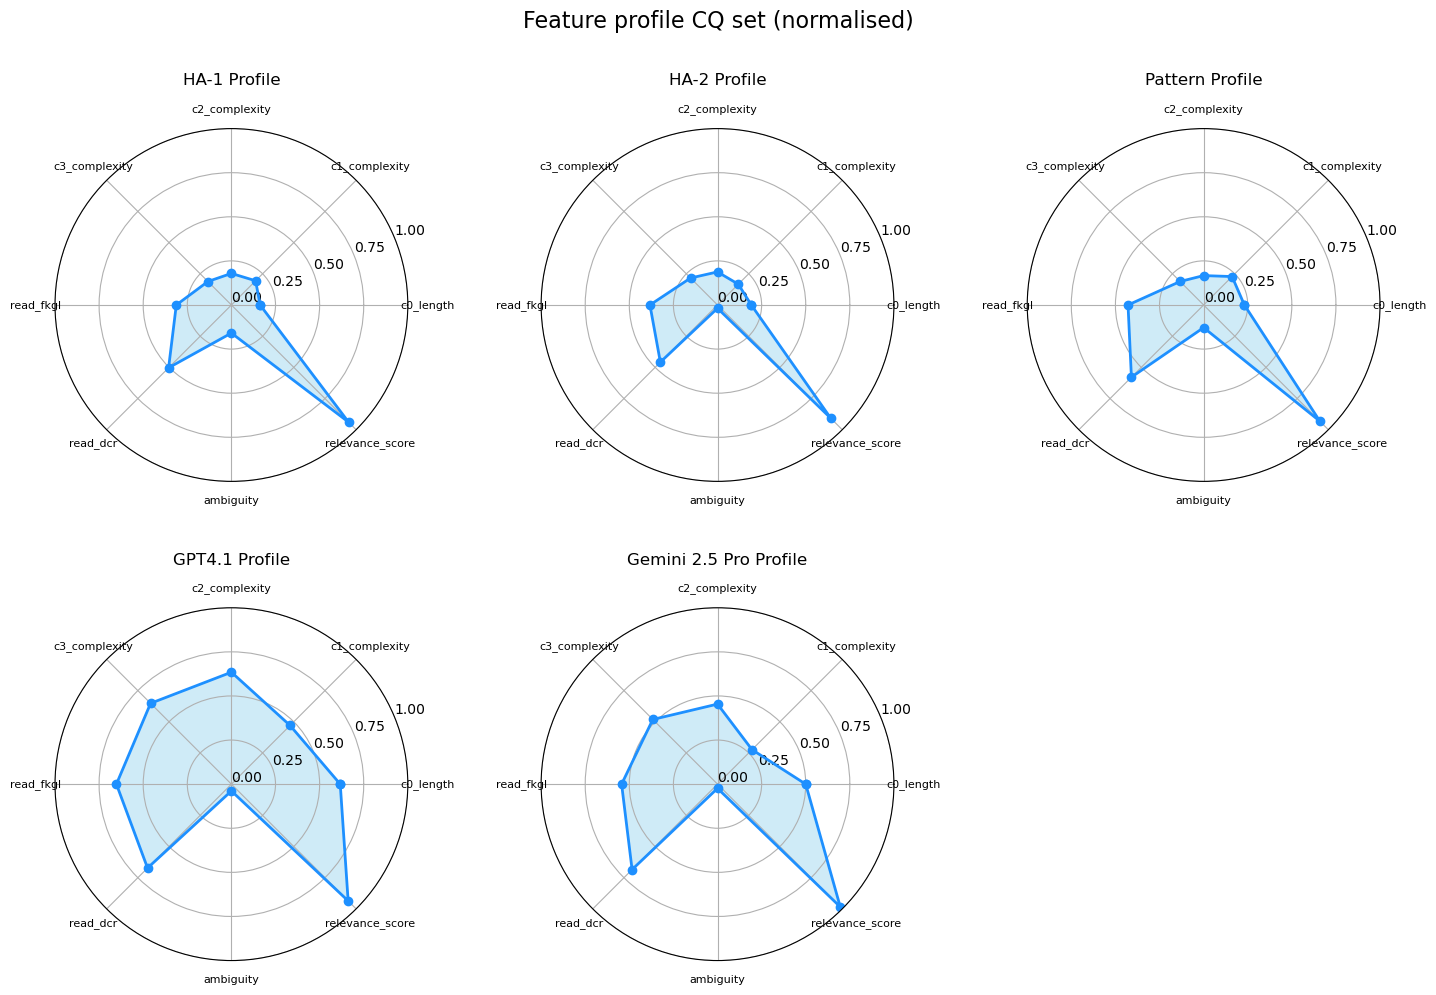

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

def create_radar_charts_for_sets_no_inversion(df: pd.DataFrame):
    """
    Generates radar charts (octagons) for different 'sets' in the DataFrame
    to visualize 8 key metrics. Metrics are scaled to a 0-1 range but
    NOT inverted. This means interpretation of each axis depends on whether
    a high or low value is desirable for that specific metric.

    Args:
        df (pd.DataFrame): DataFrame with columns: 'text', 'set', 'c0_length',
                           'c1_complexity', 'c2_complexity', 'c3_complexity', 'read_fkgl',
                           'read_dcr', 'ambiguity', 'relevance_score'.
    """
    metrics_to_plot = [
        'c0_length', 'c1_complexity', 'c2_complexity', 'c3_complexity',
        'read_fkgl', 'read_dcr', 'ambiguity', 'relevance_score'
    ]
    num_vars = len(metrics_to_plot)

    # Make a copy for processing
    plot_data = df[['set'] + metrics_to_plot].copy()

    # --- 1. Normalize Metrics (0-1 range across the entire dataset) ---
    # This step is crucial for plotting different scales on the same radar chart.
    scaler = MinMaxScaler()
    plot_data[metrics_to_plot] = scaler.fit_transform(plot_data[metrics_to_plot])
    # --- 3. Aggregate Data: Calculate mean for each 'set' ---
    radar_df_mean = plot_data.groupby('set')[metrics_to_plot].mean()
    # --- 4. Plotting ---
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]  # Close the loop for a closed polygon

    # Determine the layout of subplots
    num_sets = len(radar_df_mean)
    if num_sets == 0:
        print("No data to plot after grouping by 'set'.")
        return

    # Adjust layout based on number of sets for better visualization
    if num_sets <= 3:
        n_cols = num_sets
        n_rows = 1
    elif num_sets <= 6:
        n_cols = 3
        n_rows = (num_sets + n_cols - 1) // n_cols # ceiling division
    else: # more than 6
        n_cols = 4
        n_rows = (num_sets + n_cols - 1) // n_cols

    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols,
                             figsize=(5 * n_cols, 5 * n_rows),
                             subplot_kw={'projection': 'polar'})

    if num_sets == 1: # Handle single subplot case for axes indexing
        axes = [axes]
    else:
        axes = axes.flatten()

    for i, (set_val, row) in enumerate(radar_df_mean.iterrows()):
        if i >= len(axes): # Should not happen with dynamic subplot sizing
            break
        ax = axes[i]
        values = row.values.flatten().tolist()
        values += values[:1]  # Close the loop

        ax.plot(angles, values, 'o-', linewidth=2, color='dodgerblue', label="Mean Profile")
        ax.fill(angles, values, 'skyblue', alpha=0.4)

        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(metrics_to_plot, size=8)
        ax.set_yticks(np.arange(0, 1.1, 0.25)) # Ticks from 0 to 1 (scaled range)
        ax.set_ylim(0, 1) # Data is scaled to 0-1
        ax.set_title(f"{SET_MAPPING[set_val]} Profile", size=12, y=1.1)
        ax.grid(True)

    # Hide any unused subplots if the grid is larger than num_sets
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout(pad=3.0)
    plt.suptitle("Feature profile CQ set (normalised)", fontsize=16, y=1.02 if n_rows > 1 else 1.05)
    # plt.show()
    plt.savefig("../plots/measure_profile.pdf", bbox_inches='tight')


create_radar_charts_for_sets_no_inversion(cq_measures_df)
# save the radar charts as a pdf file


### Feature importance and score-set prediction study

In [26]:
score_regression_df = cq_measures_df.copy()
# let's drop the set, cq, relevance_rationale columns
score_regression_df = score_regression_df.drop(columns=["set"])
score_regression_df = score_regression_df.drop(columns=["cq"])
score_regression_df = score_regression_df.drop(columns=["relevance_rationale"])
# split the data into X (everything except score) and y (score)
y_reg = score_regression_df["score"]
X_reg = score_regression_df.drop(columns=["score"])

# classification dataframe, where we drop the score and classify the set
classification_df = cq_measures_df.copy()
y_cla = classification_df["set"]
X_cla = classification_df.drop(columns=["set"])
X_cla = X_cla.drop(columns=["cq"])
X_cla = X_cla.drop(columns=["score"])
X_cla = X_cla.drop(columns=["relevance_rationale"])

Baseline MSE: 1.08
Baseline R^2: -0.01
Regression MSE: 0.70
Regression R^2: 0.34


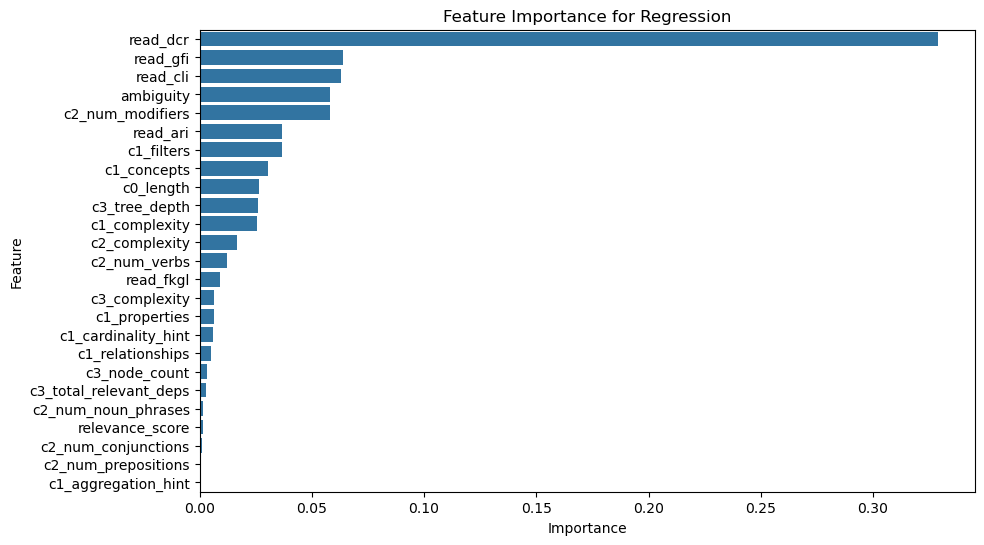

In [ ]:
# Regression experiment with feature importance
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyRegressor

# Split the data into training and test sets
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)
# Create a pipeline with a scaler and a random forest regressor
pipeline_reg = make_pipeline(StandardScaler(), RandomForestRegressor(n_estimators=100, random_state=42))
pipeline_baseline = make_pipeline(StandardScaler(), DummyRegressor(strategy="mean"))
# Fit the models
pipeline_baseline.fit(X_train_reg, y_train_reg)
pipeline_reg.fit(X_train_reg, y_train_reg)
# Make predictions
y_pred_reg = pipeline_reg.predict(X_test_reg)
y_pred_baseline = pipeline_baseline.predict(X_test_reg)
# Calculate the mean squared error and R^2 score
mse_reg = mean_squared_error(y_test_reg, y_pred_reg)
mse_baseline = mean_squared_error(y_test_reg, y_pred_baseline)
r2_reg = r2_score(y_test_reg, y_pred_reg)
r2_baseline = r2_score(y_test_reg, y_pred_baseline)
print(f"Baseline MSE: {mse_baseline:.2f}")
print(f"Baseline R^2: {r2_baseline:.2f}")
print(f"Regression MSE: {mse_reg:.2f}")
print(f"Regression R^2: {r2_reg:.2f}")

# Calculate feature importance
result_reg = permutation_importance(pipeline_reg, X_test_reg, y_test_reg, n_repeats=10, random_state=42)
# Get the feature importance
feature_importance_reg = result_reg.importances_mean
# Create a DataFrame for feature importance
feature_importance_df_reg = pd.DataFrame({
    'feature': X_reg.columns,
    'importance': feature_importance_reg
})
# Sort the DataFrame by importance
feature_importance_df_reg = feature_importance_df_reg.sort_values(by='importance', ascending=False)
# Plot the feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance_df_reg)
plt.title('Feature Importance for Regression')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


Baseline Accuracy: 0.34
Classification Accuracy: 0.68
                precision    recall  f1-score   support

          HA-1       0.17      0.17      0.17         6
          HA-2       0.69      0.64      0.67        14
       Pattern       1.00      1.00      1.00         5
        GPT4.1       0.80      1.00      0.89         8
Gemini 2.5 Pro       0.71      0.62      0.67         8

      accuracy                           0.68        41
     macro avg       0.67      0.69      0.68        41
  weighted avg       0.68      0.68      0.68        41



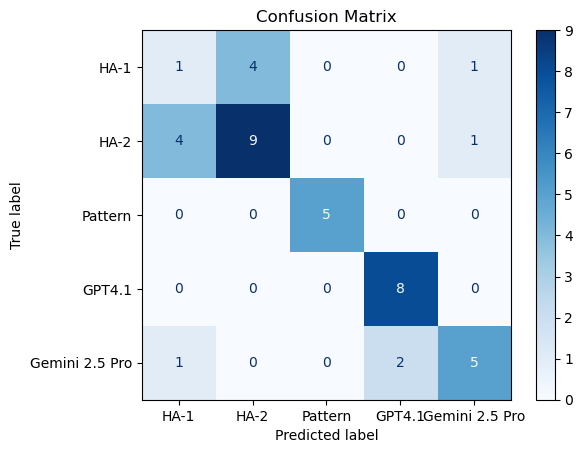

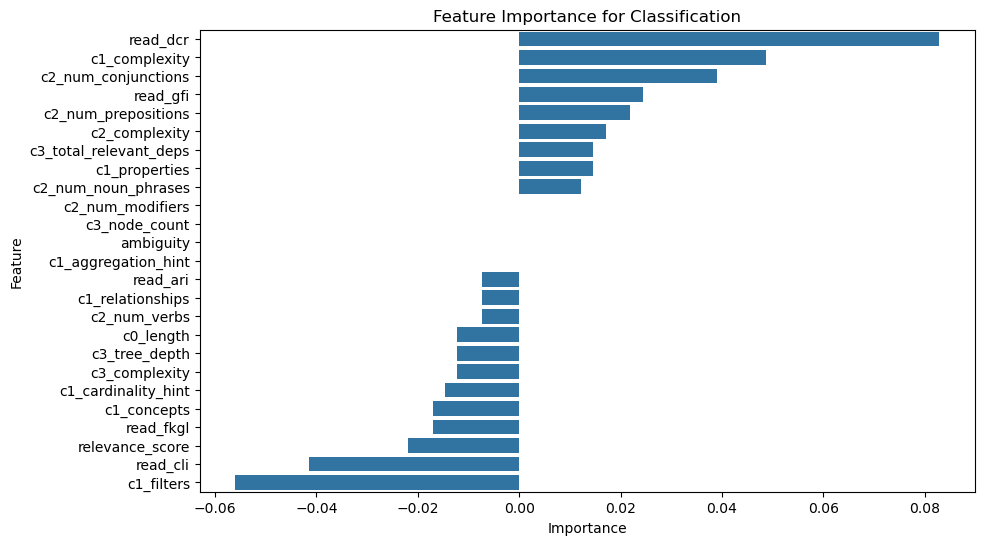

In [ ]:
# Now let's do the same for classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.inspection import permutation_importance
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# Split the data into training and test sets
X_train_cla, X_test_cla, y_train_cla, y_test_cla = train_test_split(X_cla, y_cla, test_size=0.2, random_state=42)
# Create a pipeline with a scaler and a random forest classifier
pipeline_cla = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=100, random_state=42))
pipeline_baseline_cla = make_pipeline(StandardScaler(), DummyClassifier(strategy="most_frequent"))
# Fit the models
pipeline_baseline_cla.fit(X_train_cla, y_train_cla)
pipeline_cla.fit(X_train_cla, y_train_cla)
# Make predictions
y_pred_cla = pipeline_cla.predict(X_test_cla)
y_pred_baseline_cla = pipeline_baseline_cla.predict(X_test_cla)
# Calculate the accuracy
accuracy_cla = accuracy_score(y_test_cla, y_pred_cla)
accuracy_baseline_cla = accuracy_score(y_test_cla, y_pred_baseline_cla)
print(f"Baseline Accuracy: {accuracy_baseline_cla:.2f}")
print(f"Classification Accuracy: {accuracy_cla:.2f}")
# Calculate the classification report
print(classification_report(y_test_cla, y_pred_cla, target_names=SET_MAPPING.values()))
# Calculate the confusion matrix
cm = confusion_matrix(y_test_cla, y_pred_cla, labels=list(SET_MAPPING.keys()))
# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(SET_MAPPING.values()))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()
# Calculate feature importance
result_cla = permutation_importance(pipeline_cla, X_test_cla, y_test_cla, n_repeats=10, random_state=42)
# Get the feature importance
feature_importance_cla = result_cla.importances_mean
# Create a DataFrame for feature importance
feature_importance_df_cla = pd.DataFrame({
    'feature': X_cla.columns,
    'importance': feature_importance_cla
})
# Sort the DataFrame by importance
feature_importance_df_cla = feature_importance_df_cla.sort_values(by='importance', ascending=False)
# Plot the feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance_df_cla)
plt.title('Feature Importance for Classification')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [28]:
correlation_df = cq_measures_df.copy()
# let's drop the set, cq, relevance_rationale columns
correlation_df = correlation_df.drop(columns=["set"])
correlation_df = correlation_df.drop(columns=["cq"])
correlation_df = correlation_df.drop(columns=["relevance_rationale"])

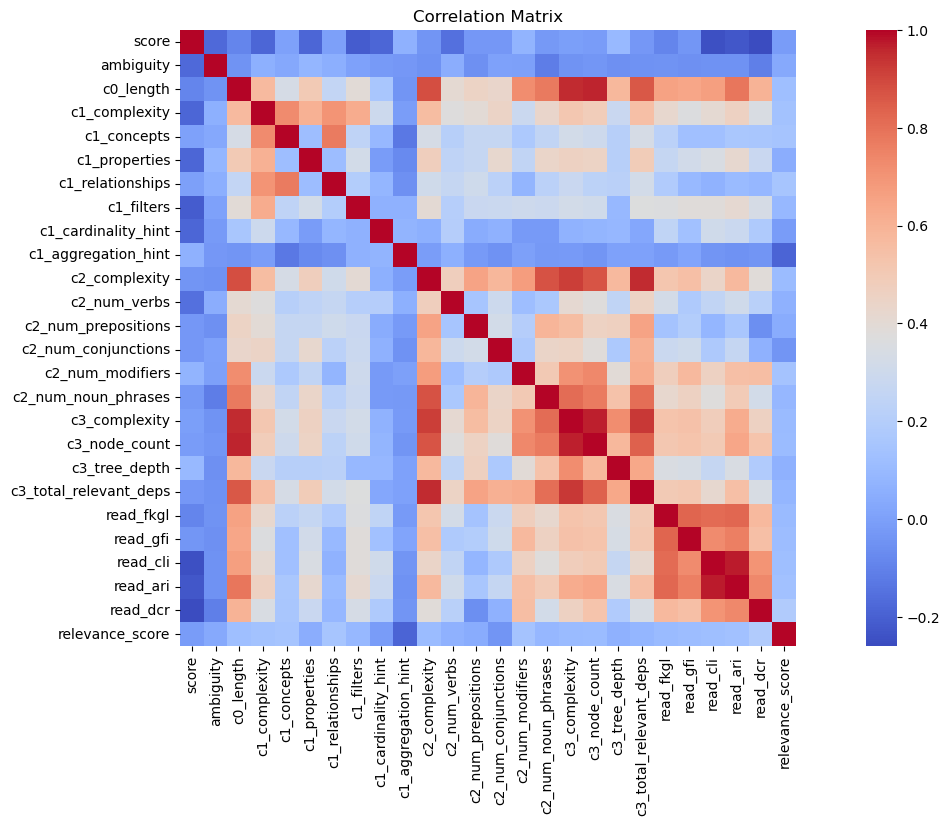

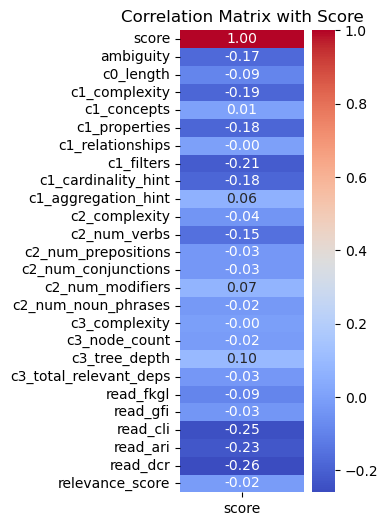

In [ ]:
# Correlate the features with the score
# 0.0: No correlation
# 0.1: Weak correlation
# 0.3: Moderate correlation
# 0.5: Strong correlation
# 0.7: Very strong correlation
# 0.9: Perfect correlation

correlation_matrix = correlation_df.corr()
# Plot the correlation matrix
plt.figure(figsize=(18, 8))
sns.heatmap(correlation_matrix, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix")
plt.show()
# Plot the correlation matrix with the score
plt.figure(figsize=(2, 6))
sns.heatmap(correlation_matrix[["score"]], annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix with Score")
plt.show()